# Cuaderno de Reflexión: Optimización en IA

**Autor:** Jesús Ariel González Bonilla  
**Fecha:** 2025-08-07

Este cuaderno sintetiza los **nueve ejercicios** prácticos de optimización desarrollados en clase, aporta claves teóricas y reflexiones críticas, y muestra fragmentos de código mínimos que puedes ejecutar.

> Ejecuta las celdas y prueba modificar parámetros para ver su impacto.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.datasets import make_regression, load_diabetes, load_breast_cancer, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import linprog
import pulp
import random, math
from skopt import gp_minimize

## 1. Gradiente Descendente Clásico

**Objetivo**: Minimizar $f(x)=x^2$ usando descenso por gradiente.

**Fórmula de actualización**:  
$$x_{t+1}=x_t-\eta 2x_t$$

**Ideas clave**:
- Convergencia lineal para $0<\eta<1/L$ con $L=2$.  
- Demuestra el efecto de la tasa de aprendizaje sobre estabilidad y velocidad.

**Reflexión**: Ajustar $\eta$ balancea rapidez y seguridad; comprender la constante de Lipschitz evita divergencia.

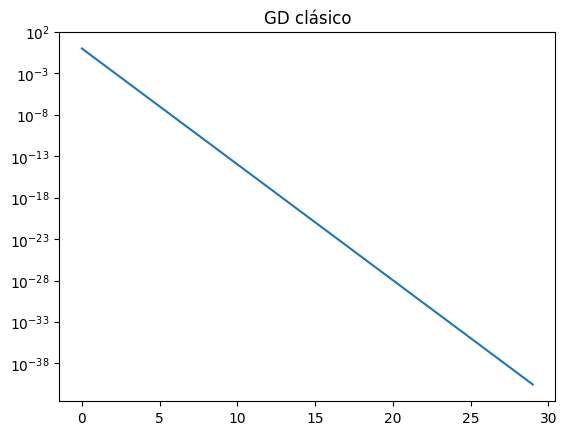

In [24]:
import numpy as np, matplotlib.pyplot as plt
x, lr, hist = 5.0, 0.4, []
for _ in range(30):
    x -= lr * 2*x
    hist.append(x**2)
plt.semilogy(hist); plt.title('GD clásico'); plt.show()

## 2. Gradiente Descendente por Mini-batch

**Objetivo**: Comparar GD completo con mini-batch.

- El gradiente estimado para un lote $B$ reduce su varianza con $1/|B|$.  
- Mini-batch acelera iteraciones pero introduce ruido.

**Reflexión**: Encontrar tamaño de lote "dulce" depende del hardware y la forma de la función de pérdida.

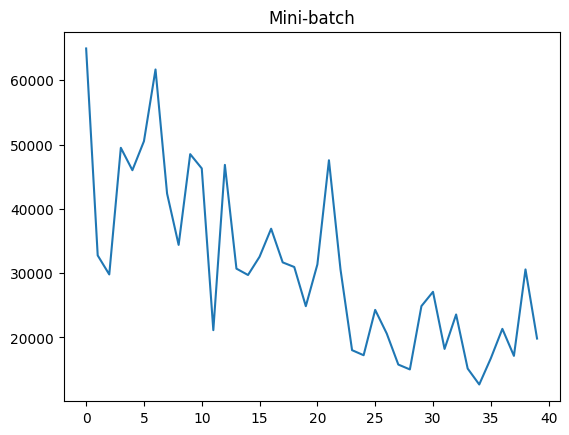

In [25]:
import torch, torch.nn as nn, matplotlib.pyplot as plt
from sklearn.datasets import make_regression
X,y = make_regression(n_samples=256,n_features=10,noise=4.0)
X,y = map(torch.tensor,[X,y.reshape(-1,1)])
loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X.float(),y.float()),batch_size=32,shuffle=True)
m=nn.Linear(10,1); opt=torch.optim.SGD(m.parameters(),lr=1e-3); loss=nn.MSELoss()
hist=[]
for epoch in range(40):
    for xb,yb in loader:
        opt.zero_grad(); l=loss(m(xb),yb); l.backward(); opt.step()
    hist.append(l.item())
plt.plot(hist); plt.title('Mini-batch'); plt.show()

## 3. Mini‑batch con Dataset Diabetes

**Objetivo**: Aplicar mini‑batch GD real en un problema de regresión.

- Normalizar características mejora isotropía de la pérdida.  
- Early stopping evita sobreajuste.

**Reflexión**: Combinar teoría de escalamiento con validación cruzada aumenta robustez.

In [26]:
# Ejemplo rápido de early stopping en diabetes
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
X,y = load_diabetes(return_X_y=True)
X = StandardScaler().fit_transform(X)
model = SGDRegressor(alpha=0.0001, learning_rate='invscaling', eta0=0.01)
best, patience, wait = 1e9, 5, 0
for epoch in range(300):
    model.partial_fit(X,y)
    mse = mean_squared_error(y, model.predict(X))
    if mse < best: best, wait = mse, 0
    else: wait+=1
    if wait>patience: break
print('epochs', epoch, 'best mse', best)

epochs 288 best mse 2864.651584877881


## 4. Gradiente Descendente Estocástico (SGD)

**Objetivo**: Observar la trayectoria ruidosa de SGD.

- Convergencia esperada $\mathcal{O}(1/\sqrt{t})$.  
- Momentum suaviza y acelera.

**Reflexión**: El barajado de datos y la política de tasa de aprendizaje son tan importantes como la fórmula del gradiente.

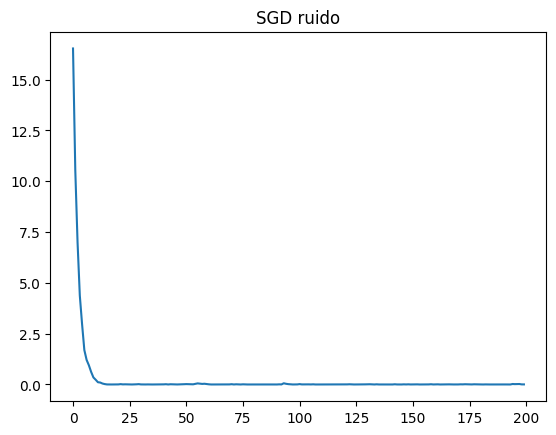

In [27]:
import numpy as np, matplotlib.pyplot as plt, random
def f(x): return x**2
lr=0.1; x=5; fs=[]
for i in range(200):
    grad=2*x+np.random.randn()*0.5
    x-=lr*grad
    fs.append(f(x))
plt.plot(fs); plt.title('SGD ruido'); plt.show()

## 5. Programación Lineal Clásica

**Objetivo**: Formular y resolver un problema LP de utilidad.

- Comparación de Simplex vs. barrera interior.  
- Dualidad para interpretar precios sombra.

**Reflexión**: La lectura económica del dual convierte números en decisiones.

In [28]:
from scipy.optimize import linprog
c = [-5,-4]         # maximizar -> minimizar negativo
A = [[2,1],[1,1]]
b = [10,8]
res = linprog(c, A_ub=A, b_ub=b, bounds=(0,None))
print('Óptimo', -res.fun, 'en x=', res.x)

Óptimo 34.0 en x= [2. 6.]


## 6. Programación Lineal en Dataset Cáncer de Mama

**Objetivo**: Maximizar margen con restricciones lineales.

- Uso de holguras cuando no hay separación perfecta.  
- Paralelo con SVM lineal.

**Reflexión**: Reformular modelos clásicos en LP ilumina la frontera entre aprendizaje y optimización.

In [29]:
# Separación lineal como LP simplificada con pulp
import pulp, numpy as np
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X,y = data.data[:50,:2], (data.target[:50]*2-1)  # submuestra 2D
prob = pulp.LpProblem('margin', pulp.LpMaximize)
w1 = pulp.LpVariable('w1'); w2 = pulp.LpVariable('w2'); b = pulp.LpVariable('b'); rho = pulp.LpVariable('rho', lowBound=0)
prob += rho
for i in range(len(X)):
    prob += y[i]*(w1*X[i,0]+w2*X[i,1]+b) >= rho
prob.solve(pulp.PULP_CBC_CMD(msg=0))
print('Márgen', rho.value())

Márgen 3.4188207e-11


## 7. Algoritmos Metaheurísticos

**Objetivo**: Explorar Rastrigin con heurísticas.

- Recocido simulado vs. algoritmo genético.  
- Balance diversificación/intensificación.

**Reflexión**: Las heurísticas necesitan métricas claras para no perderse en su propia estocasticidad.

In [30]:
import random, math
def rastrigin(v): return 10*len(v)+sum(x**2-10*math.cos(2*math.pi*x) for x in v)
best=[random.uniform(-5,5) for _ in range(2)]
T=1.0
for k in range(5000):
    cand=[x+random.gauss(0,0.3) for x in best]
    if random.random()<math.exp((rastrigin(best)-rastrigin(cand))/T):
        best=cand
    T*=0.999
print('Best', rastrigin(best))

Best 0.027608072720546772


## 8. Optimización de Hiperparámetros

**Objetivo**: Comparar Grid Search y Random Search.

- Random Search cubre mejor espacios de alta dimensión con pocas evaluaciones.  
- Métricas múltiples (F1, AUC) guían la selección.

**Reflexión**: El costo de exploración debe sopesarse contra el rendimiento marginal.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
X,y = load_wine(return_X_y=True)
param_space={'n_estimators':[50,100,200],'max_depth':[None,3,5,7]}
rs=RandomizedSearchCV(RandomForestClassifier(),param_space,n_iter=5,cv=3,scoring='accuracy')
rs.fit(X,y)
print('Mejor score', rs.best_score_)

Mejor score 0.9606403013182674


## 9. Optimización Bayesiana

**Objetivo**: Minimizar caja negra con procesos gaussianos y Expected Improvement.

- Surrogate model equilibra exploración y explotación.  
- Kernel y parámetro $\xi$ controlan agresividad.

**Reflexión**: Pensar en términos de *valor de información* conduce a estrategias de búsqueda más inteligentes.

In [32]:
from skopt import gp_minimize
def f(x):
    import math
    return (x[0]-2)**2+math.sin(5*x[0])
res = gp_minimize(f, [(-5.0,5.0)], n_calls=20, random_state=0)
print('x*', res.x[0], 'f*', res.fun)

x* 1.0315052035069723 f* 0.03543050263408409


## Conclusiones Finales

- Las técnicas de **descenso por gradiente** son la espina dorsal del aprendizaje profundo; su comportamiento depende fuertemente de la tasa de aprendizaje y del tamaño de lote.
- **Programación lineal** sigue vigente: ofrece interpretabilidad y garantías cuando el modelo es lineal.
- **Metaheurísticas** proporcionan alternativas en espacios no convexos, pero requieren criterios de parada y análisis estadístico.
- La **optimización de hiperparámetros** combina exploración y explotación; métodos bayesianos ahorran evaluaciones cuando los modelos son costosos.
- Cualquier experimento de optimización debe acompañarse de **visualización, validación cruzada** y un registro reproducible de configuraciones.